<h1>Install required libraries</h1>

In [1]:
!pip install albumentations pytorch-metric-learning --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.9/125.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.0 MB/s eta 0:00:00:00:0100:01


<h1>Library</h1>

In [2]:
import time
import os
import cv2
import torch
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
from torch.cuda.amp import GradScaler, autocast
from torchvision import models
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics.pairwise import cosine_similarity
warnings.filterwarnings("ignore", category=UserWarning)

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


<h1>Device</h1>

In [3]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

Using device: cuda
GPU: Tesla T4
Memory: 14.74 GB


<h1>Hyperparameters </h1>

In [4]:
# Hyperparameters and paths
train_dir = "/kaggle/input/data-augmented-model-2/augmented_data_model_2"
test_dir  = "/kaggle/input/logo-verify-test/logo_verify_test"
INPUT_SIZE = 224
BATCH_SIZE = 64
EMBEDDING_DIM = 256
TEMPERATURE = 0.07
LR = 3e-4
WEIGHT_DECAY = 1e-4
NUM_EPOCHS = 50
ACCUM_STEPS = 2  # Gradient accumulation steps

print(f"Training directory: {train_dir}")
print(f"Test directory: {test_dir}")

Training directory: /kaggle/input/data-augmented-model-2/augmented_data_model_2
Test directory: /kaggle/input/logo-verify-test/logo_verify_test


<h1>Show check data and Visualization</h1>

Dataset: /kaggle/input/data-augmented-model-2/augmented_data_model_2
 - Number of classes: 135
 - Total images: 103302
 - Images per class: min=480, max=2436, avg=765.20


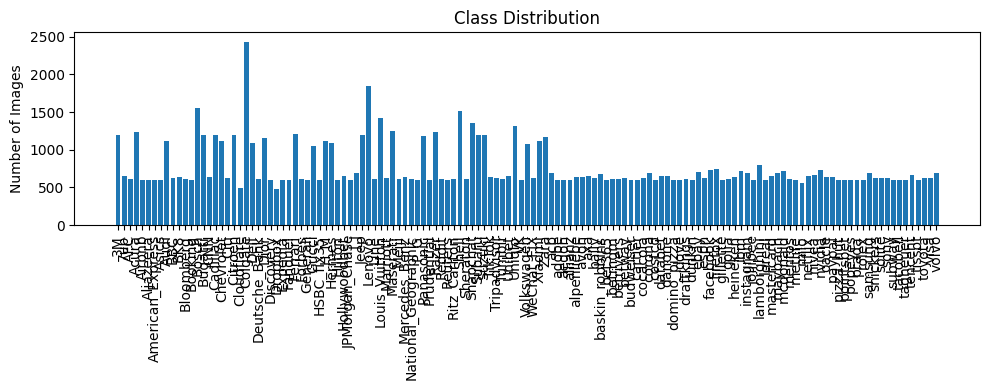

Dataset: /kaggle/input/logo-verify-test/logo_verify_test
 - Number of classes: 50
 - Total images: 683
 - Images per class: min=10, max=29, avg=13.66


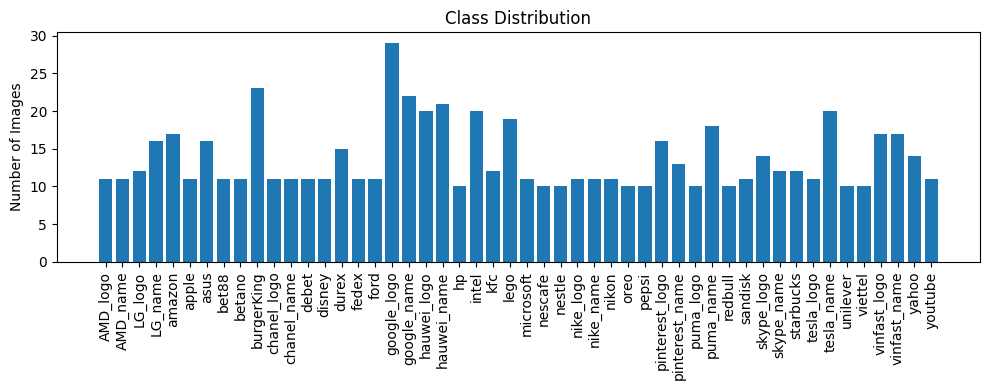

In [5]:
def analyze_dataset(directory):
    class_names = sorted([d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))])
    num_classes = len(class_names)
    class_counts = {}
    total_images = 0
    min_images = float('inf')
    max_images = 0
    for cls in class_names:
        cls_dir = os.path.join(directory, cls)
        num_images = len([f for f in os.listdir(cls_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        class_counts[cls] = num_images
        total_images += num_images
        min_images = min(min_images, num_images)
        max_images = max(max_images, num_images)
    avg_images = total_images / num_classes if num_classes > 0 else 0
    print(f"Dataset: {directory}")
    print(f" - Number of classes: {num_classes}")
    print(f" - Total images: {total_images}")
    print(f" - Images per class: min={min_images}, max={max_images}, avg={avg_images:.2f}")
    # Plot class distribution
    plt.figure(figsize=(10, 4))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.xticks(rotation=90)
    plt.title("Class Distribution")
    plt.ylabel("Number of Images")
    plt.tight_layout()
    plt.show()
    return class_counts

# Analyze train and test datasets
train_class_counts = analyze_dataset(train_dir)
test_class_counts  = analyze_dataset(test_dir)

<h1>Transform</h1>

In [6]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
os.environ['NO_ALBUMENTATIONS_UPDATE'] = '1'

# Define training and test transformations
def get_transforms():
    train_transform = A.Compose([
        A.Resize(height=INPUT_SIZE, width=INPUT_SIZE),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.3),
        A.Affine(translate_percent={"x": 0.05, "y": 0.05},
                 scale=(0.9, 1.1),
                 rotate=(-15, 15), p=0.5),
        A.OneOf([
            A.GaussNoise(var_limit=(10.0, 50.0)),
            A.GaussianBlur(blur_limit=(3, 5)),
        ], p=0.3),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])
    test_transform = A.Compose([
        A.Resize(height=INPUT_SIZE, width=INPUT_SIZE),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])
    return train_transform, test_transform

train_transform, test_transform = get_transforms()

<h2>Check data Augment</h2>

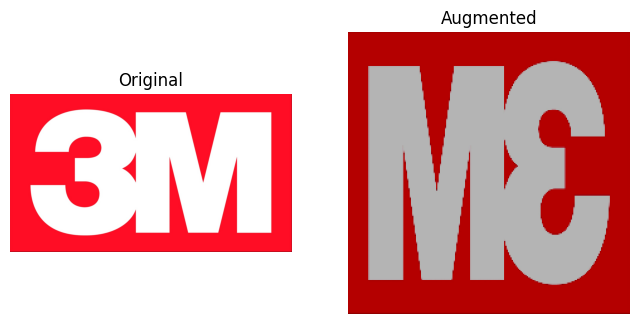

In [7]:
# Utility to un-normalize tensor for visualization
def unnormalize(img_tensor):
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    return (img_np * std + mean).clip(0, 1)

# Visualize an example augmentation
sample_class = next(iter(train_class_counts.keys())) if train_class_counts else None
if sample_class:
    sample_dir = os.path.join(train_dir, sample_class)
    sample_img_name = os.listdir(sample_dir)[0]
    sample_img_path = os.path.join(sample_dir, sample_img_name)
    img = cv2.imread(sample_img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    aug_img_tensor = train_transform(image=img)["image"]
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.imshow(img); plt.title("Original"); plt.axis('off')
    plt.subplot(1,2,2); plt.imshow(unnormalize(aug_img_tensor)); plt.title("Augmented"); plt.axis('off')
    plt.show()


<h1>DataLoader</h1>

Initialized ContrastiveDataset with 135 classes and 103302 images.


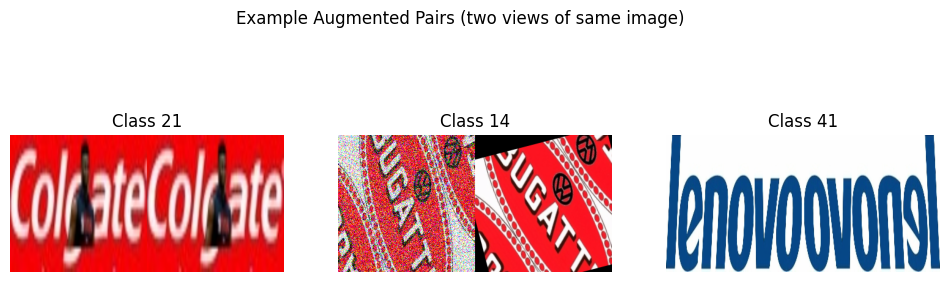

In [8]:
class ContrastiveDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.root_dir = root_dir
        self.transform = transform
        # Build list of (image_path, label) pairs
        self.samples = []
        self.class_to_idx = {}
        classes = sorted(d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d)))
        for idx, cls in enumerate(classes):
            self.class_to_idx[cls] = idx
            cls_dir = os.path.join(root_dir, cls)
            for fname in os.listdir(cls_dir):
                if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.samples.append((os.path.join(cls_dir, fname), idx))
        self.num_samples = len(self.samples)
        print(f"Initialized ContrastiveDataset with {len(classes)} classes and {self.num_samples} images.")
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        # Load image (with fallback to PIL if cv2 fails)
        try:
            img = cv2.imread(img_path)
            if img is None:
                raise IOError
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        except Exception as e:
            img = np.array(Image.open(img_path).convert('RGB'))
        # Apply two independent augmentations
        img1 = self.transform(image=img)["image"]
        img2 = self.transform(image=img)["image"]
        return img1, img2, label

# Initialize the contrastive training dataset and loader
train_dataset = ContrastiveDataset(train_dir, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=4, pin_memory=True, persistent_workers=True)

# Display a few sample pairs from the dataset (concatenate augmented pairs side by side)
def show_augmented_pairs(dataset, n=3):
    indices = np.random.choice(len(dataset), n, replace=False)
    plt.figure(figsize=(12,4))
    for i, idx in enumerate(indices):
        img1, img2, label = dataset[idx]
        pair_img = np.hstack([unnormalize(img1), unnormalize(img2)])
        plt.subplot(1, n, i+1)
        plt.imshow(pair_img)
        plt.title(f"Class {label}")
        plt.axis('off')
    plt.suptitle("Example Augmented Pairs (two views of same image)")
    plt.show()

show_augmented_pairs(train_dataset, n=3)


<h1>BACBONE</h1>

<h2>RESNET 50</h2>

In [9]:
# import torch
# import torch.nn as nn
# from torchvision import models

# class Network(nn.Module):
#     def __init__(self, emb_dim=256):
#         super(Network, self).__init__()

#         base_model = models.resnet50(pretrained=True)

#         # Bỏ layer cuối cùng (fc)
#         self.backbone = nn.Sequential(*list(base_model.children())[:-1])  # Output: [B, 2048, 1, 1]

#         # FC Head
#         self.fc = nn.Sequential(
#             nn.Linear(2048, 512),
#             nn.PReLU(),
#             nn.Linear(512, emb_dim)
#         )

#     def forward(self, x):
#         x = self.backbone(x)           # [B, 2048, 1, 1]
#         x = torch.flatten(x, 1)        # [B, 2048]
#         x = self.fc(x)                 # [B, emb_dim]
#         return x

<h2>RESNET 18</h2>

In [10]:
class Network(nn.Module):
    def __init__(self, emb_dim=256):
        super(Network, self).__init__()
        base_model = models.resnet18(pretrained=True)
        self.backbone = nn.Sequential(*list(base_model.children())[:-1])
        
        self.projection = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, emb_dim)
        )
        
    def forward(self, x):
        x = self.backbone(x)
        x = torch.flatten(x, 1)
        x = self.projection(x)
        return x
        
# Initialize model and move to device (GPU if available)
model = Network(emb_dim=EMBEDDING_DIM).to(device)
# Quick check of model output dimensions
dummy_input = torch.randn(2, 3, INPUT_SIZE, INPUT_SIZE).to(device)
dummy_output = model(dummy_input)
print(f"Model output shape (for 2 samples): {dummy_output.shape}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 171MB/s] 


Model output shape (for 2 samples): torch.Size([2, 256])


<h1>Loss NT-Xent (InfoNCE) for Contrastive Learning</h1>

In [11]:
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature
        self.softmax = nn.CrossEntropyLoss()
    def forward(self, z_i, z_j):
        B = z_i.shape[0]
        # Normalize embeddings
        z_i = F.normalize(z_i, dim=1)
        z_j = F.normalize(z_j, dim=1)
        # Concatenate [2B, D] and compute full similarity matrix
        z = torch.cat([z_i, z_j], dim=0)  # 2B x D
        sim_matrix = torch.mm(z, z.t()) / self.temperature  # cosine similarity matrix (2B x 2B)
        # Mask out self-similarities (diagonal)
        mask = torch.eye(2*B, device=z.device, dtype=torch.bool)
        sim_matrix = sim_matrix.masked_fill(mask, float('-inf'))
        # Create labels: 0..B-1 match with B..2B-1 (positive pairs)
        targets = torch.arange(B, 2*B, device=z.device)
        # For the first B entries in sim_matrix, the target positive is at index [i + B]
        # For the second B entries, the target positive is at index [i - B]
        # We can create the labels accordingly:
        labels = torch.cat((targets, targets - B))
        # Compute cross entropy loss
        loss = self.softmax(sim_matrix, labels)
        return loss

# Initialize loss, optimizer, and learning rate scheduler
criterion = NTXentLoss(temperature=TEMPERATURE)
optimizer = Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
scaler = GradScaler()

print("Optimizer and loss initialized.")

Optimizer and loss initialized.


/tmp/ipykernel_35/4196923723.py:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


<h2>Check Model</h2>

In [12]:
# model = Network(EMBEDDING_DIM).to(device)
# dummy_input = torch.randn(32, 3, INPUT_SIZE, INPUT_SIZE).to(device)
# output = model(dummy_input)
# print(f"Model output shape: {output.shape}")

# criterion = NTXentLoss(temperature=TEMPERATURE)
# optimizer = Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
# scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5, verbose=True)
# scaler = GradScaler()

<h1>Test Function</h1>

In [13]:
from numpy.linalg import norm

def evaluate_one_shot(test_dir, model, transform, device):
    model.eval()
    reference_embeddings = {}
    # Compute reference embeddings for each class (images containing '000000')
    for cls in sorted(os.listdir(test_dir)):
        cls_path = os.path.join(test_dir, cls)
        if not os.path.isdir(cls_path):
            continue
        # Find reference image file (contains '000000')
        ref_files = [f for f in os.listdir(cls_path) if '000000' in f]
        if not ref_files:
            continue
        ref_img_path = os.path.join(cls_path, ref_files[0])
        img = cv2.imread(ref_img_path)
        if img is None:
            img = np.array(Image.open(ref_img_path).convert('RGB'))
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Transform and embed
        img_t = transform(image=img)["image"].unsqueeze(0).to(device)
        with torch.no_grad():
            emb = model(img_t)
            emb = F.normalize(emb, dim=1).cpu().numpy().squeeze()
        reference_embeddings[cls] = emb
    if not reference_embeddings:
        return 0.0, []
    # Evaluate each test image by nearest reference
    correct = 0
    total = 0
    results = []
    for cls in sorted(os.listdir(test_dir)):
        cls_path = os.path.join(test_dir, cls)
        if not os.path.isdir(cls_path):
            continue
        for fname in os.listdir(cls_path):
            if '000000' in fname:  # skip reference image
                continue
            img_path = os.path.join(cls_path, fname)
            img = cv2.imread(img_path)
            if img is None:
                img = np.array(Image.open(img_path).convert('RGB'))
            else:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_t = transform(image=img)["image"].unsqueeze(0).to(device)
            with torch.no_grad():
                test_emb = model(img_t)
                test_emb = F.normalize(test_emb, dim=1).cpu().numpy().squeeze()
            # Compute cosine similarity with each reference embedding
            # (Since embeddings are normalized, cosine similarity = dot product)
            similarities = {ref_cls: np.dot(test_emb, ref_emb) 
                            for ref_cls, ref_emb in reference_embeddings.items()}
            # Predict the class with highest similarity
            pred_cls, sim_val = max(similarities.items(), key=lambda x: x[1])
            is_correct = (pred_cls == cls)
            results.append({
                'image_path': img_path,
                'true_class': cls,
                'predicted_class': pred_cls,
                'similarity': sim_val,
                'is_correct': is_correct
            })
            if is_correct:
                correct += 1
            total += 1
    acc = correct / total if total > 0 else 0.0
    return acc, results

# Quick test of evaluation function on untrained model (expected low accuracy)
test_acc, _ = evaluate_one_shot(test_dir, model, test_transform, device)
print(f"Initial one-shot test accuracy (untrained model): {test_acc:.4f}")


Initial one-shot test accuracy (untrained model): 0.4771


<h1>Initialize Dataset</h1>

In [14]:
# # 1. Khởi tạo datasets
# raw_ds = OptimizedImageDataset(train_dir)
# pair_ds = FastPairDataset(raw_ds, train_transform, max_pairs=100000)

# # 2. Tạo DataLoader với num_workers cao
# train_loader = DataLoader(
#     pair_ds,
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     num_workers=4,
#     pin_memory=True,
#     persistent_workers=True
# )

# # Kiểm tra một batch
# batch = next(iter(train_loader))
# imgs1, imgs2, labels = batch
# print(f"Batch shapes: imgs1 {imgs1.shape}, imgs2 {imgs2.shape}, labels {labels.shape}")

# # Hiển thị batch
# plt.figure(figsize=(15, 7))
# for i in range(4):
#     plt.subplot(2, 4, i*2+1)
#     plt.imshow(unnormalize(imgs1[i]))
#     plt.title(f"Label: {labels[i].item()}")
#     plt.axis('off')
    
#     plt.subplot(2, 4, i*2+2)
#     plt.imshow(unnormalize(imgs2[i]))
#     plt.axis('off')
# plt.suptitle("Batch Samples (Left: Anchor, Right: Positive/Negative)")
# plt.show()

<h1>Train Loop</h1>

In [16]:
import csv
from datetime import datetime

# Prepare CSV log file with header
log_file = "training_log.csv"
with open(log_file, mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow([
        'timestamp', 'epoch', 'train_loss', 'val_acc', 
        'learning_rate', 'best_acc', 'epoch_time', 'evaluated', 'num_train_samples'
    ])

best_acc = 0.0
history = {'loss': [], 'acc': []}

print("Starting training...")
for epoch in range(1, NUM_EPOCHS + 1):
    epoch_start = time.time()
    model.train()
    running_loss = 0.0
    # Determine if we should evaluate this epoch
    evaluate_this_epoch = (epoch % 10 == 0) or (epoch == NUM_EPOCHS)
    # Training loop
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS}", leave=False)
    optimizer.zero_grad()
    for i, (x1, x2, _) in enumerate(progress_bar):
        x1 = x1.to(device, non_blocking=True)
        x2 = x2.to(device, non_blocking=True)
        # Forward passes with mixed precision
        with autocast():
            z1 = model(x1)  # embedding for first views
            z2 = model(x2)  # embedding for second views
            loss = criterion(z1, z2) / ACCUM_STEPS
        scaler.scale(loss).backward()
        # Gradient accumulation step
        if (i + 1) % ACCUM_STEPS == 0 or (i + 1) == len(train_loader):
            # Gradient clipping for stability
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            # Optimizer step
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        running_loss += loss.item() * ACCUM_STEPS  # scale back the loss
        progress_bar.set_postfix(loss=(running_loss / (i + 1)))
    avg_loss = running_loss / len(train_loader)
    history['loss'].append(avg_loss)
    # Validation (one-shot evaluation) every 10 epochs or final epoch
    if evaluate_this_epoch:
        val_acc, val_results = evaluate_one_shot(test_dir, model, test_transform, device)
        history['acc'].append(val_acc)
        # Save best model if accuracy improved
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_loss,
                'val_acc': val_acc,
                'val_results': val_results
            }, 'best_model.pth')
    else:
        val_acc = None
    # Step the learning rate scheduler
    scheduler.step()
    epoch_time = time.time() - epoch_start
    # Log epoch details to CSV
    with open(log_file, mode='a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([
            datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            epoch,
            avg_loss,
            val_acc if val_acc is not None else "",
            optimizer.param_groups[0]['lr'],
            best_acc,
            f"{epoch_time:.2f}",
            evaluate_this_epoch,
            len(train_dataset)
        ])
    # Print epoch summary
    summary = (f"Epoch {epoch:02d}/{NUM_EPOCHS} - Loss: {avg_loss:.4f}")
    if evaluate_this_epoch:
        summary += f" - Val Acc: {val_acc:.4f}"
    summary += f" - LR: {optimizer.param_groups[0]['lr']:.6f} - Time: {epoch_time:.2f}s"
    summary += f" - Best Val Acc: {best_acc:.4f}"
    print(summary)
    # Save periodic checkpoint
    if epoch % 1 == 0:
        torch.save(model.state_dict(), f"checkpoint_epoch_{epoch}.pth")

print("Training complete.")
print(f"Best one-shot accuracy achieved: {best_acc:.4f}")


Starting training...


RuntimeError: DataLoader worker (pid(s) 103, 104, 105, 106) exited unexpectedly